In [1]:
import os
from datetime import datetime, timedelta
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import random
from sklearn.model_selection import train_test_split
from functools import partial
#from tensorboardX import SummaryWriter

/home/youling/anaconda3/envs/dinov2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = {
    'my_network': 'resnet50',
    'dino_model': 'dinov2_vits14',
    'pretrain_choice': 'unfrozen',
    'num_cls': 2,
    'dropout': 0.5,
    'out_is_feature': True,
    'use_patch_tokens': True,
    'use_blocks':[3,6,9,12],        # 融合使用从输入开始的第几个block的特征

    'memo': 'use_oneimg[1,2,3]_',
    'print_to_file': False,         # 是否将print输出到文件

    'lr': 1e-4,
    'batch_size': 16,
    'epoch': 50,                    # 学习率重启的周期:30,70,150,310
    'num_set': 10,
    'seed': 114514,
    'img_size': 224,
    'num_workers': 8,               # 4 or 11

    'loss': 'cross_entropy',
    'optimizer': 'adam',            # adam, sgd
    'scheduler': 'step',            # None,cosinewarm, cosine, step
    'scheduler_step_size': 25,

    'device': 'cuda:0',
    'save_dir': '/mnt/ssd/HUANGYouling/result/607',
    'root_dir': '/mnt/ssd/HUANGYouling/medical_dataset',
}

In [3]:
# 读取cfg,并且应用
num_classes = cfg['num_cls']
img_size = cfg['img_size']
batch_size = cfg['batch_size']
epoch = cfg['epoch']
num_set = cfg['num_set']       # 用一个set或者用全部的10个
learning_rate = cfg['lr']
seed = cfg['seed']
pretrain_choice = cfg['pretrain_choice']
model_name = cfg['dino_model']


root_dir = cfg['root_dir']
data_name = f'CT_sets_{num_set}'

save_dir = cfg['save_dir']
dino_model_name = cfg['dino_model']

blocks = cfg['use_blocks']
patchtokens = cfg['use_patch_tokens']
memo = cfg['memo']

print(f'model_name: {model_name},\npretrain_choice: {pretrain_choice},\nlearning rate: {learning_rate},\nbach_size: {batch_size},\n\
epoch: {epoch},\nnum_set: {num_set}')

device = torch.device(cfg['device'])
my_datetime = (datetime.now()+timedelta(hours=9)).strftime('%m-%d_%H:%M')
save_name = f'{memo}_{model_name}_blocks({blocks}_patchtokens{patchtokens}_param{pretrain_choice}_{data_name}_{my_datetime}'

model_name: dinov2_vits14,
pretrain_choice: unfrozen,
learning rate: 0.0001,
bach_size: 16,
epoch: 50,
num_set: 10


In [4]:
# 设置随机种子
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(cfg['seed'])

#### 设置输出文件信息

In [5]:
import sys 
# 结果保存信息
save_path = os.path.join(save_dir, save_name)
#writer = SummaryWriter('/mnt/ssd/HUANGYouling/logs', comment=save_name)

# 定义文件名和路径
output_file_name = f"{save_path}/{datetime.now().strftime('%d')}/output_file_{my_datetime}.txt"

# 打开文件并将标准输出重定向到文件
def redirect_stdout_to_file(file_name):
    file = open(file_name, "a")  # 使用 "a" 模式以追加的方式打开文件
    sys.stdout = file  # 将标准输出重定向到文件
    return file

# 恢复标准输出
def restore_stdout(file):
    sys.stdout = sys.__stdout__  # 恢复标准输出
    file.close()  # 关闭文件

# 输出和日志记录函数
def log_and_print(message, file_name, print_to_file=cfg['print_to_file']):
    print(message)
    if print_to_file:
        file = redirect_stdout_to_file(file_name)
        print(message)
        restore_stdout(file)


In [6]:
class MedicalDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.file_list = self.get_file_list()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        data = torch.load(file_path)  # 加载.pth文件
        image = data['image']   
        clinical = data['clinical']
        label = data['label'].astype('float32')
        label = np.argmax(label)            # 将 one-hot 编码[1,0]的 label 转换为类别索引[0]

        # Convert each grayscale image to 3-channel RGB
        nc_image = Image.fromarray(image[:,:,0].astype('uint8')).convert('RGB')
        art_image = Image.fromarray(image[:,:,1].astype('uint8')).convert('RGB')
        pv_image = Image.fromarray(image[:,:,2].astype('uint8')).convert('RGB')
        image = Image.fromarray(image.astype('uint8'))

        if self.transform:
            image = self.transform(image)
            nc_image = self.transform(nc_image)
            art_image = self.transform(art_image)
            pv_image = self.transform(pv_image)

        return {'image':image, 'NC': nc_image, 'ART': art_image, 'PV': pv_image, 'clinical': clinical, 'label': label}

    def get_file_list(self):
        file_list = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.pth'):
                    file_list.append(file)
        return file_list


In [7]:
train_transform = transforms.Compose(
      [
      transforms.CenterCrop(img_size),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(degrees=15),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.152, 0.233, 0.305], std=[0.063, 0.068, 0.089]) # 在全数据集上计算得到
])

val_transform = transforms.Compose([
      transforms.CenterCrop(img_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.152, 0.233, 0.305], std=[0.063, 0.068, 0.089])
])

## 模型构造

### 模型1 
1. 通过cfg['use_patch_tokens']来判断是否使用patch tokens [num_patch=256, dims=384]
2. `neck_1结构`: 池化patch tokens,并且调整形状对齐cls后, 与 cls token [1,dims=384] concat后得到feature
3. feature通过一个linear层分类  

In [8]:
class ModelWithIntermediateLayers(nn.Module):
    def __init__(self, feature_model, n_last_blocks, autocast_ctx):
        super().__init__()
        self.feature_model = feature_model
        self.feature_model.eval()
        self.n_last_blocks = n_last_blocks
        self.autocast_ctx = autocast_ctx

    def forward(self, images):
        with torch.inference_mode():
            with self.autocast_ctx():
                features = self.feature_model.get_intermediate_layers(
                    images, self.n_last_blocks, return_class_token=True
                )
        return features


def neck_1(x_tokens_list, use_n_blocks=1, use_avgpool=True):
    # use_avgpool: 选择是否使用 patch token 的平均值 , 与 cls token 拼接后输出为feature
    # 并且拼接之后feature token的长度是 cls token的两倍
    patchtokens = x_tokens_list[-use_n_blocks][0]  # 选择倒数第几层的输出
    cls = x_tokens_list[-use_n_blocks][1]         
    output = cls
    if use_avgpool:
        output = torch.cat( (  output, torch.mean(patchtokens, dim=1),), dim=-1, )   # patch tokens
        output = output.reshape(output.shape[0], -1)       # 将feature的最后两个维度展平,[2,dims]->[2*dims]
    return output.float()

class dino1(nn.Module):
    def __init__(self, cfg=None):
        super(dino1, self).__init__()
        model = torch.hub.load('facebookresearch/dinov2', cfg['dino_model'], pretrained=True)

        autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=torch.float16)
        self.tokens_list_extractor = ModelWithIntermediateLayers(model, n_last_blocks=list(range(12)), autocast_ctx=autocast_ctx) # 提取所有12层的输出
        self.use_patch_tokens = cfg['use_patch_tokens']
        self.use_blocks = cfg['use_blocks']

        if cfg['pretrain_choice'] == 'frozen':
            for param in model.parameters():
                param.requires_grad = False

        self.input_linear = model.embed_dim * 3
        if cfg['use_patch_tokens']:
            self.input_linear *= 2         # 经过拼接之后的feature长度是cls的2倍
        self.input_linear *= len(self.use_blocks)             # 4个层的feature拼接 
        self.linear = nn.Linear(self.input_linear, cfg['num_cls'])
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def extract_feature(self, x):
        full_block_tokens_turple = self.tokens_list_extractor(x)        
        # 上一行full_block_tokens_turple是个[12,2]的turple矩阵
        # 第0层对应vit的第12层,每一个元素是一个tensor
        # tokens_turple[0,:] = [ patch_tokens [batch_size=32, num_patchs=256, dims=384], cls_token[patch_size, dims]  ]
        feature = []
        for n_block in self.use_blocks:
            n_last_block = 13-n_block                       # 将正序号转换为倒序号
            one_layer_block_tokens = neck_1(full_block_tokens_turple, use_n_blocks=n_last_block, use_avgpool=self.use_patch_tokens) 
            # 上一行代码将patch tokens与clstoken连接
            # one_layer_block_tokens的shape是[batch_size, 2*dims]
            feature.append(one_layer_block_tokens)
        tensor_feature = torch.cat((feature), dim=1)
        return tensor_feature

    def forward(self, x1, x2, x3):
        f_NC = self.extract_feature(x1)  # (batch_size, embed_dim )=(1, 384))
        f_ART = self.extract_feature(x2)
        f_PV = self.extract_feature(x3)
        feature = torch.cat((f_NC, f_ART, f_PV), dim=1)
        pre = self.linear(feature)
        return pre

### 模型2  (待完成)
与模型1不同点在于使用 `neck2结构`,使用卷积操作来降维patch tokens,然后与cls token concat后得到feature

In [9]:
def autopad(k, p=None):  # kernel, padding
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv1d(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):
        super().__init__()
        self.conv = nn.Conv1d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm1d(c2)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class neck_2(nn.Module):
    def __init__(self, c_in, c_out):
        super(neck_2, self).__init__()
        self.conv1d = Conv1d(c_in, c_out, kernel_size=1)
    
    def forward(self, x_tokens_list, use_n_blocks=1, use_patch_tokens=True):
        tokens = x_tokens_list[-use_n_blocks:]
        cls = torch.cat([class_token for _, class_token in tokens], dim=-1)  # cls token

        if use_patch_tokens:
            patch_tokens = tokens[-1][0]  # 取最后一层的 patch tokens
            # 通过 1x1 卷积
            conv_output = self.conv1d(patch_tokens.transpose(1, 2)).transpose(1, 2)
            output = torch.cat((cls, conv_output.view(conv_output.size(0), -1)), dim=-1)
            output = output.reshape(output.shape[0], -1)                # 维度变换为(batch_size, dims)，用于 fc 层之前

        return output


class dino2(nn.Module):
    def __init__(self, cfg=None):
        super(dino2, self).__init__()
        model = torch.hub.load('facebookresearch/dinov2', cfg['dino_model'], pretrained=True)

        autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=torch.float16)
        self.tokens_list_extractor = ModelWithIntermediateLayers(model, n_last_blocks=1, autocast_ctx=autocast_ctx)
        self.use_avgpool = cfg['use_patch_tokens']
        self.neck_2 = neck_2(model.embed_dim * 2, model.embed_dim)

        if cfg['pretrain_choice'] == 'frozen':
            for param in model.parameters():
                param.requires_grad = False

        self.input_linear = model.embed_dim * 3
        if cfg['use_patch_tokens']:
            self.input_linear *= 2         # 经过拼接之后的feature长度是cls的2倍

        self.linear = nn.Linear(self.input_linear, cfg['num_cls'])
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def extract_feature(self, x):
        tokens_list = self.tokens_list_extractor(x)
        feature = neck_2(tokens_list, use_n_blocks=1, use_avgpool=self.use_avgpool)
        return feature

    def forward(self, x1, x2, x3):
        f1 = self.extract_feature(x1)  # (batch_size, embed_dim )=(1, 384))
        f2 = self.extract_feature(x2)
        f3 = self.extract_feature(x3)
        feature = torch.cat((f1, f2, f3), dim=1)

        pre = self.linear(feature)
        return pre

## baseline from Wang weibin
resnet50

In [10]:
class resnet50(nn.Module):
    def __init__(self, cfg=None):
        super(resnet50, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=True)
        if cfg['pretrain_choice'] == 'frozen':
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        self.linearinput = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()
        self.fc = nn.Linear(self.linearinput, cfg['num_cls'])

    def forward(self, x1, x2=None, x3=None):
        f_1 = self.feature_extractor(x1)
        # f_2 = self.feature_extractor(x2)
        # f_3 = self.feature_extractor(x3)
        #feature = torch.cat((f_1, f_2, f_3), dim=1)
        pre = self.fc(f_1)
        return pre

class resnet18(nn.Module):
    def __init__(self, cfg=None):
        super(resnet18, self).__init__()
        self.feature_extractor = models.resnet18(pretrained=True)
        if cfg['pretrain_choice'] == 'frozen':
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        self.linearinput = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()
        self.fc = nn.Linear(self.linearinput, cfg['num_cls'])

    def forward(self, x1, x2=None, x3=None):
        f_1 = self.feature_extractor(x1)
        # f_2 = self.feature_extractor(x2)
        # f_3 = self.feature_extractor(x3)
        #feature = torch.cat((f_1, f_2, f_3), dim=1)
        pre = self.fc(f_1)
        return pre

### 训练

In [11]:
os.makedirs(save_path, exist_ok=True)
#输出模型设置以及结果
output_file_name = f"{save_path}/output_file_{my_datetime}.txt"
output_file = redirect_stdout_to_file(output_file_name)
out_print = '\n'.join([f'{key}: {value}' for key, value in cfg.items()])
log_and_print(out_print, output_file_name)

# 定义存储结果的列表
set_train_loss_list,set_train_acc_list,set_val_loss_list,set_val_acc_list, set_val_auc_list, \
                set_test_auc_list,set_test_loss_list,set_test_acc_list = [],[],[],[],[],[],[],[]

# 网络模型的初始化
def get_save_model(cfg):
    if cfg['my_network'] == 'dino1':
        model = dino1(cfg).to(device)
    elif cfg['my_network'] == 'dino2':
        model = dino2(cfg).to(device)
    elif cfg['my_network'] == 'resnet50':
        model = resnet50(cfg).to(device)
    elif cfg['my_network'] == 'resnet18':
        model = resnet18(cfg).to(device)
    initial_model_path = f'/mnt/ssd/HUANGYouling/temp_model/{save_name}.pth'        # 为了每个set开始时都能复原模型参数,临时保存初始参数
    torch.save(model.state_dict(), initial_model_path)
    return model, initial_model_path
# 损失函数,优化器,学习率调度器的初始化
def initialize_experiment(cfg, model, initial_model_path, device):
    model.load_state_dict(torch.load(initial_model_path))
    model.to(device)

    if cfg['loss'] == 'cross_entropy':
        criterion = nn.CrossEntropyLoss()

    if cfg['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=1e-4)
    elif cfg['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=0.9, weight_decay=0)

    if cfg['scheduler'] == 'cosinewarm':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10,T_mult=2, eta_min=1e-6)
    elif cfg['scheduler'] == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg['epoch'], eta_min=0)
    elif cfg['scheduler'] == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler_step_size'], gamma=0.1)
    elif cfg['scheduler'] == 'None':
        scheduler = None

    return model, criterion, optimizer, scheduler
# 每一次实验set的数据集的初始化
def initial_dataloader(cfg,root_dir,set_id,train_transform,val_transform):
    full_train_dataset = MedicalDataset(root=f'{root_dir}/{set_id}/train', transform=train_transform)
    train_dataset, val_dataset = train_test_split(full_train_dataset, test_size=0.2, random_state=42)   # 8:2划分训练集和验证集
    test_dataset = MedicalDataset(root=f'{root_dir}/{set_id}/test', transform=val_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, num_workers=cfg['num_workers'], pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=cfg['num_workers'], pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=cfg['num_workers'], pin_memory=True)
    return train_loader, val_loader, test_loader

def train_one_epoch(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for batch in train_loader:
        # images_NC, image_art, image_pv, targets = batch['NC'].to(device), batch['ART'].to(device), batch['PV'].to(device), batch['label'].to(device)
        # optimizer.zero_grad()
        # outputs = model(images_NC, image_art, image_pv)

        images, targets = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == targets)

    epoch_loss = running_loss / len(train_loader.dataset)   # 使用train_dataset的长度
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc

def evaluate(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for batch in loader:
            # images_NC, image_art, image_pv, targets = batch['NC'].to(device), batch['ART'].to(device), batch['PV'].to(device), batch['label'].to(device)
            # outputs = model(images_NC, image_art, image_pv)
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(images) 
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            probabilities = torch.softmax(outputs, dim=1)
            all_targets.extend(labels.cpu().detach().numpy())
            all_probabilities.extend(probabilities.cpu().detach().numpy())
            

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    # 提取正类的概率
    all_probabilities_1d = np.array([prob[1] for prob in all_probabilities])
    epoch_auc = roc_auc_score(all_targets, all_probabilities_1d, multi_class='ovr')

    return epoch_loss, epoch_acc, epoch_auc

model, initial_model_path = get_save_model(cfg)         #设定并且保存模型参数

for set_id in range(num_set):  # 数据集有 10 个 set
    # 每个set开始时复原模型参数和实验设定
    model, criterion, optimizer, scheduler = initialize_experiment(cfg, model, initial_model_path, device)
    #model = nn.DataParallel(model)              # 多GPU并行
    train_loader, val_loader, test_loader = initial_dataloader(cfg,root_dir, set_id, train_transform, val_transform)


    train_loss_list, train_acc_list, val_loss_list, val_acc_list, val_auc_list, \
                test_auc_list, test_loss_list, test_acc_list = [], [], [], [], [], [], [], []


    for i in range(epoch):
        file = redirect_stdout_to_file(output_file_name)
        print('-'*5, f'Set [{set_id+1}/{num_set}] Epoch [{i+1}/{epoch}] stared', '-'*5)
        restore_stdout(file)

        epoch_train_loss, epoch_train_acc = train_one_epoch(train_loader, model, criterion, optimizer, device)  # 训练一个epoch        
        epoch_val_loss, epoch_val_acc, epoch_val_auc = evaluate(val_loader, model, criterion, device)
        epoch_test_loss, epoch_test_acc, epoch_test_auc = evaluate(test_loader, model, criterion, device)

        # 更新学习率
        if scheduler is not None:        
            epoch_lr = scheduler.get_last_lr()[0]   
            scheduler.step()
        else:
            epoch_lr = optimizer.param_groups[0]['lr']

            
        # 输出每个 epoch 的结果
        epoch_log = (f'Set [{set_id+1}/{num_set}], Epoch [{i+1}/{epoch}],\n '
                     f'Train Acc: {epoch_train_acc:.4f}, Train Loss: {epoch_train_loss:.4f},   '
                     f'Val Acc: {epoch_val_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val AUC: {epoch_val_auc:.4f},\n '
                     f'Test Acc: {epoch_test_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test AUC: {epoch_test_auc:.4f}, LR: {epoch_lr:.6f}')
        log_and_print(epoch_log, output_file_name)


        train_loss_list.append(epoch_train_loss),   train_acc_list.append(epoch_train_acc) 
        val_loss_list.append(epoch_val_loss),       val_acc_list.append(epoch_val_acc), val_auc_list.append(epoch_val_auc)
        test_loss_list.append(epoch_test_loss),     test_acc_list.append(epoch_test_acc), test_auc_list.append(epoch_test_auc)
    
    # 保存val_loss最低的验证结果
    epoch_index = val_loss_list.index(min(val_loss_list))

    # 记录每个 set 按策略选定的epoch的结果
    set_train_loss_list.append(train_loss_list[epoch_index]), set_train_acc_list.append(train_acc_list[epoch_index])
    set_val_acc_list.append(val_acc_list[epoch_index]), set_val_loss_list.append(val_loss_list[epoch_index])
    set_test_acc_list.append(test_acc_list[epoch_index]), set_test_loss_list.append(test_loss_list[epoch_index])
    set_val_auc_list.append(val_auc_list[epoch_index]), set_test_auc_list.append(test_auc_list[epoch_index])

    # 输出每个 set 的结果
    set_log = (f'\nSet [{set_id+1}/{num_set}] result:\n'
               f'Best epoch based on mini-Val-Loss: \n'
               f'Train Acc: {train_acc_list[epoch_index]:.4f}, Train Loss: {train_loss_list[epoch_index]:.4f},\n '
               f'Val Acc: {val_acc_list[epoch_index]:.4f}, Val Loss: {val_loss_list[epoch_index]:.4f},  AUC: {val_auc_list[epoch_index]:.4f},\n '
               f'Test Acc: {test_acc_list[epoch_index]:.4f}, Test Loss: {test_loss_list[epoch_index]:.4f}, Test AUC: {test_auc_list[epoch_index]:.4f}\n')
    log_and_print(set_log, output_file_name)

# 输出整个 10 个 set 的平均结果
avg_train_loss = sum(set_train_loss_list) / len(set_train_loss_list)
avg_train_acc = sum(set_train_acc_list) / len(set_train_acc_list)
avg_val_loss = sum(set_val_loss_list) / len(set_val_loss_list)
avg_val_acc = sum(set_val_acc_list) /  len(set_val_acc_list)
avg_test_acc = sum(set_test_acc_list) / len(set_test_acc_list)
avg_test_loss = sum(set_test_loss_list) / len(set_test_loss_list)
avg_test_auc = sum(set_test_auc_list) / len(set_test_auc_list)

final_log = (f'\nOverall results across all sets:\n'
             f'Avg Train Acc: {avg_train_acc:.4f}, Avg Train Loss: {avg_train_loss:.4f}, '
             f'Avg Val Acc: {avg_val_acc:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Avg AUC: {avg_test_auc:.4f}'
             f'Avg Test Acc: {avg_test_acc:.4f}, Avg Test Loss: {avg_test_loss:.4f}, Avg AUC: {avg_test_auc:.4f}\n')
log_and_print(final_log, output_file_name)

torch.save(model, save_path+'/model.pth')

/home/youling/anaconda3/envs/dinov2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/youling/anaconda3/envs/dinov2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Set [1/10], Epoch [1/50],
 Train Acc: 0.6097, Train Loss: 0.6518,   Val Acc: 0.6403, Val Loss: 0.6633, Val AUC: 0.7147,
 Test Acc: 0.6857, Test Loss: 0.9001, Test AUC: 0.6675, LR: 0.000100
Set [1/10], Epoch [2/50],
 Train Acc: 0.8129, Train Loss: 0.4016,   Val Acc: 0.6475, Val Loss: 0.7101, Val AUC: 0.7476,
 Test Acc: 0.6286, Test Loss: 1.0091, Test AUC: 0.7092, LR: 0.000100
Set [1/10], Epoch [3/50],
 Train Acc: 0.8867, Train Loss: 0.2639,   Val Acc: 0.6906, Val Loss: 0.6923, Val AUC: 0.7679,
 Test Acc: 0.6143, Test Loss: 0.8200, Test AUC: 0.7859, LR: 0.000100
Set [1/10], Epoch [4/50],
 Train Acc: 0.9245, Train Loss: 0.1963,   Val Acc: 0.6835, Val Loss: 0.6839, Val AUC: 0.8041,
 Test Acc: 0.6286, Test Loss: 1.1594, Test AUC: 0.6716, LR: 0.000100
Set [1/10], Epoch [5/50],
 Train Acc: 0.9496, Train Loss: 0.1292,   Val Acc: 0.6259, Val Loss: 1.0672, Val AUC: 0.7128,
 Test Acc: 0.6571, Test Loss: 0.8079, Test AUC: 0.7549, LR: 0.000100
Set [1/10], Epoch [6/50],
 Train Acc: 0.9550, Train Los

/home/youling/anaconda3/envs/dinov2/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Set [3/10], Epoch [1/50],
 Train Acc: 0.5971, Train Loss: 0.6585,   Val Acc: 0.6642, Val Loss: 0.6869, Val AUC: 0.6923,
 Test Acc: 0.6585, Test Loss: 0.6688, Test AUC: 0.8038, LR: 0.000100
Set [3/10], Epoch [2/50],
 Train Acc: 0.7930, Train Loss: 0.4520,   Val Acc: 0.7007, Val Loss: 0.6831, Val AUC: 0.7725,
 Test Acc: 0.5122, Test Loss: 1.0378, Test AUC: 0.6500, LR: 0.000100
Set [3/10], Epoch [3/50],
 Train Acc: 0.8773, Train Loss: 0.2896,   Val Acc: 0.6715, Val Loss: 0.8208, Val AUC: 0.7650,
 Test Acc: 0.6707, Test Loss: 0.7680, Test AUC: 0.8306, LR: 0.000100
Set [3/10], Epoch [4/50],
 Train Acc: 0.9066, Train Loss: 0.2190,   Val Acc: 0.7226, Val Loss: 0.7210, Val AUC: 0.8210,
 Test Acc: 0.6220, Test Loss: 0.7618, Test AUC: 0.7144, LR: 0.000100
Set [3/10], Epoch [5/50],
 Train Acc: 0.8810, Train Loss: 0.2895,   Val Acc: 0.7591, Val Loss: 0.5875, Val AUC: 0.8496,
 Test Acc: 0.6341, Test Loss: 1.1165, Test AUC: 0.7645, LR: 0.000100
Set [3/10], Epoch [6/50],
 Train Acc: 0.9469, Train Los

Set [10/10], Epoch [50/50],
 Train Acc: 1.0000, Train Loss: 0.0024,   Val Acc: 0.8201, Val Loss: 0.5560, Val AUC: 0.8774,
 Test Acc: 0.6216, Test Loss: 1.2448, Test AUC: 0.5685, LR: 0.000010

Set [10/10] result:
Best epoch based on mini-Val-Loss: 
Train Acc: 0.6141, Train Loss: 0.6624,
 Val Acc: 0.7482, Val Loss: 0.4822,  AUC: 0.8747,
 Test Acc: 0.6757, Test Loss: 0.5897, Test AUC: 0.7722


Overall results across all sets:
Avg Train Acc: 0.7971, Avg Train Loss: 0.3826, Avg Val Acc: 0.7180, Avg Val Loss: 0.6178, Avg AUC: 0.5708Avg Test Acc: 0.5550, Avg Test Loss: 1.4476, Avg AUC: 0.5708


Overall results across all sets:
Avg Train Acc: 0.7971, Avg Train Loss: 0.3826, Avg Val Acc: 0.7180, Avg Val Loss: 0.6178, Avg AUC: 0.5708Avg Test Acc: 0.5550, Avg Test Loss: 1.4476, Avg AUC: 0.5708



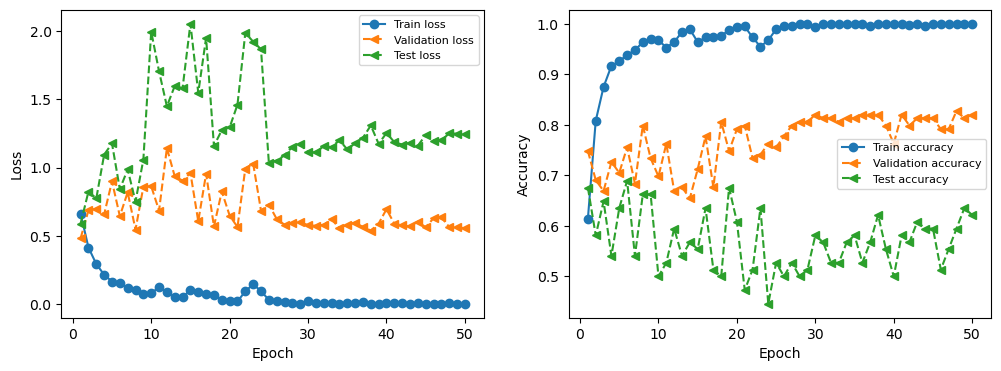

In [13]:
#学習曲線の描画
train_acc = []
train_loss = []
val_acc = []
val_loss = []
test_acc = []
test_loss = []

x_arr = range(1, epoch + 1)
for i in range(epoch):
  train_acc.append(train_acc_list[i].cpu().detach().numpy())
  train_loss.append(train_loss_list[i])
  val_acc.append(val_acc_list[i].cpu().detach().numpy())
  val_loss.append(val_loss_list[i])
  test_acc.append(test_acc_list[i].cpu().detach().numpy())
  test_loss.append(test_loss_list[i])

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the training and validation loss
ax[0].plot(x_arr, train_loss, '-o', label='Train loss')
ax[0].plot(x_arr, val_loss, '--<', label='Validation loss')
ax[0].plot(x_arr, test_loss, '--<', label='Test loss')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Epoch', size=10)
ax[0].set_ylabel('Loss', size=10)

# Plot the training and validation accuracy on the second subplot
ax[1].plot(x_arr, train_acc, '-o', label='Train accuracy')
ax[1].plot(x_arr, val_acc, '--<', label='Validation accuracy')
ax[1].plot(x_arr, test_acc, '--<', label='Test accuracy')
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Epoch', size=10)
ax[1].set_ylabel('Accuracy', size=10)

plt.savefig(f'{save_path}/learning_curve.png')
plt.show()

In [14]:
# # 绘制ROC曲线图
# fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.savefig(save_path+f'/ROC_Curve.png')
# plt.show()

### 全参数冻结,在整个数据集上验证